# Building Efficient Lightweight CNN Models on CIFAR-10
## Implementation of arXiv:2501.15547 with Improvements

This notebook implements the complete research paper "Building Efficient Lightweight CNN Models" and includes comprehensive improvements and analysis.


## 1. Imports and Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [2]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph


def compute_model_flops(model, input_shape=(1, 32, 32, 3)):
    """Estimate FLOPs for a Keras model."""
    inputs = tf.TensorSpec(input_shape, tf.float32)
    concrete = tf.function(model).get_concrete_function(inputs)
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, options=opts)
    return flops.total_float_ops if flops is not None else 0


def measure_inference_time(model, sample_batch, repeats=50):
    """Measure average inference time in seconds."""
    times = []
    for _ in range(repeats):
        start = time.time()
        _ = model.predict(sample_batch, verbose=0)
        times.append(time.time() - start)
    return float(np.mean(times))



In [3]:
class WarmupCosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        if self.warmup_steps > 0:
            warmup_lr = self.base_lr * (step / tf.cast(self.warmup_steps, tf.float32))
            cosine_lr = 0.5 * self.base_lr * (1 + tf.cos(
                np.pi * (step - self.warmup_steps) /
                tf.cast(self.total_steps - self.warmup_steps + 1e-8, tf.float32)
            ))
            return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)
        cosine_lr = 0.5 * self.base_lr * (1 + tf.cos(np.pi * step / tf.cast(self.total_steps, tf.float32)))
        return cosine_lr


class DropoutScheduler(callbacks.Callback):
    def __init__(self, layer_names, max_rate=0.4, min_rate=0.2, total_epochs=50):
        super().__init__()
        self.layer_names = layer_names
        self.max_rate = max_rate
        self.min_rate = min_rate
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / max(1, self.total_epochs - 1)
        new_rate = self.max_rate - (self.max_rate - self.min_rate) * progress
        for name in self.layer_names:
            if name in [layer.name for layer in self.model.layers]:
                self.model.get_layer(name).rate = float(new_rate)



In [4]:
import math


class MixupCutmixGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=128, mixup_alpha=0.2, cutmix_alpha=1.0, cutmix_prob=0.5, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_prob = cutmix_prob
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[batch_indices].copy()
        batch_y = self.y[batch_indices].copy()
        if len(batch_x) < 2:
            return batch_x, batch_y
        if np.random.rand() < self.cutmix_prob:
            return self._apply_cutmix(batch_x, batch_y)
        return self._apply_mixup(batch_x, batch_y)

    def _sample_beta(self, alpha):
        return np.random.beta(alpha, alpha)

    def _apply_mixup(self, x, y):
        lam = self._sample_beta(self.mixup_alpha)
        indices = np.random.permutation(len(x))
        mixed_x = lam * x + (1 - lam) * x[indices]
        mixed_y = lam * y + (1 - lam) * y[indices]
        return mixed_x, mixed_y

    def _rand_bbox(self, size, lam):
        h, w = size[1], size[2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(w * cut_rat)
        cut_h = int(h * cut_rat)

        cx = np.random.randint(w)
        cy = np.random.randint(h)

        x1 = np.clip(cx - cut_w // 2, 0, w)
        x2 = np.clip(cx + cut_w // 2, 0, w)
        y1 = np.clip(cy - cut_h // 2, 0, h)
        y2 = np.clip(cy + cut_h // 2, 0, h)
        return x1, y1, x2, y2

    def _apply_cutmix(self, x, y):
        lam = self._sample_beta(self.cutmix_alpha)
        indices = np.random.permutation(len(x))
        shuffled_x = x[indices]
        shuffled_y = y[indices]
        x1, y1, x2, y2 = self._rand_bbox(x.shape, lam)
        x[:, y1:y2, x1:x2, :] = shuffled_x[:, y1:y2, x1:x2, :]
        lam_adjusted = 1 - ((x2 - x1) * (y2 - y1) / (x.shape[1] * x.shape[2]))
        y = lam_adjusted * y + (1 - lam_adjusted) * shuffled_y
        return x, y



In [5]:
def squeeze_excite_block(inputs, ratio=16, name_prefix='se'):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D(name=f'{name_prefix}_gap')(inputs)
    se = layers.Dense(filters // ratio, activation='relu', name=f'{name_prefix}_fc1')(se)
    se = layers.Dense(filters, activation='sigmoid', name=f'{name_prefix}_fc2')(se)
    se = layers.Reshape((1, 1, filters), name=f'{name_prefix}_reshape')(se)
    return layers.Multiply(name=f'{name_prefix}_scale')([inputs, se])


def residual_block(inputs, filters, kernel_size=(3, 3), name_prefix='res', use_se=False):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, name=f'{name_prefix}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu1')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    if use_se:
        x = squeeze_excite_block(x, ratio=16, name_prefix=f'{name_prefix}_se')
    if inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same', name=f'{name_prefix}_shortcut')(inputs)
        shortcut = layers.BatchNormalization(name=f'{name_prefix}_shortcut_bn')(shortcut)
    else:
        shortcut = inputs
    x = layers.Add(name=f'{name_prefix}_add')([x, shortcut])
    x = layers.ReLU(name=f'{name_prefix}_relu2')(x)
    return x


def build_residual_lightweight_model(use_se=False, dropout_rate=0.3, num_classes=10):
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='stem_conv')(inputs)
    x = layers.MaxPooling2D((2, 2), name='stem_pool')(x)

    x = residual_block(x, 32, name_prefix='block1', use_se=use_se)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    x = residual_block(x, 64, name_prefix='block2', use_se=use_se)
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)

    x = layers.Dense(128, activation='relu', name='dense_proj')(x)
    x = layers.Dropout(dropout_rate, name='improved_dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='improved_output')(x)
    return models.Model(inputs, outputs, name='residual_lightweight_model')



In [6]:
def train_and_evaluate_model(model, train_data, val_data, test_data, epochs=30, batch_size=128,
                             optimizer=None, loss_fn=None, callbacks_list=None, class_weights=None,
                             variant_name='Variant'):
    if optimizer is None:
        optimizer = optimizers.Adam(learning_rate=0.001)
    if loss_fn is None:
        loss_fn = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        batch_size=batch_size if not isinstance(train_data, keras.utils.Sequence) else None,
        callbacks=callbacks_list or [],
        class_weight=class_weights,
        verbose=1
    )
    training_time = time.time() - start_time

    test_metrics = model.evaluate(test_data[0], test_data[1], verbose=0)
    y_pred = model.predict(test_data[0], verbose=0)
    y_true = np.argmax(test_data[1], axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    return {
        'model': model,
        'history': history,
        'training_time': training_time,
        'test_loss': float(test_metrics[0]),
        'test_accuracy': float(test_metrics[1]),
        'y_true': y_true,
        'y_pred_classes': y_pred_classes,
        'y_pred_probs': y_pred
    }



In [7]:
def plot_history(history, title_prefix, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2, linestyle='--')
    axes[0].set_title(f'{title_prefix} - Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val', linewidth=2, linestyle='--')
    axes[1].set_title(f'{title_prefix} - Loss', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [8]:
def plot_confusion_matrix(y_true, y_pred, labels, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [9]:
def log_experiment(name, result_dict):
    params = count_parameters(result_dict['model'])
    size_mb = get_model_size_mb(result_dict['model'])
    flops = compute_model_flops(result_dict['model'])
    inference_time = measure_inference_time(result_dict['model'], x_test[:1])
    experiment_records.append({
        'model': name,
        'variant': name,
        'test_acc': result_dict['test_accuracy'],
        'params': params,
        'train_time_s': result_dict['training_time'],
        'infer_time_ms': inference_time * 1000,
        'model_size_mb': size_mb,
        'flops': flops
    })
    return params, size_mb, flops, inference_time


In [10]:
def measure_latency_stats(model, sample, repeats=50, device='/CPU:0'):
    timings = []
    for _ in range(repeats):
        start = time.time()
        with tf.device(device):
            _ = model.predict(sample, verbose=0)
        timings.append(time.time() - start)
    timings = np.array(timings)
    return {
        'mean_ms': float(timings.mean() * 1000),
        'p50_ms': float(np.percentile(timings, 50) * 1000),
        'p90_ms': float(np.percentile(timings, 90) * 1000),
        'p99_ms': float(np.percentile(timings, 99) * 1000)
    }



In [11]:
def compute_training_throughput(num_samples, training_time_s):
    return num_samples / training_time_s if training_time_s > 0 else 0.0



In [12]:
def get_gpu_memory_info():
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        return {'current': None, 'peak': None}
    try:
        info = tf.config.experimental.get_memory_info('GPU:0')
        return {'current': info['current'] / (1024 ** 2), 'peak': info['peak'] / (1024 ** 2)}
    except Exception:
        return {'current': None, 'peak': None}



## 2. Data Loading and Preprocessing


In [13]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nClass distribution in training set:")
for i, name in enumerate(class_names):
    print(f"  {name}: {np.sum(y_train == i)}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Class distribution in training set:
  airplane: 5000
  automobile: 5000
  bird: 5000
  cat: 5000
  deer: 5000
  dog: 5000
  frog: 5000
  horse: 5000
  ship: 5000
  truck: 5000


## 3. Baseline Implementation - Stage 1: Dual-Input-Output Model

### 3.1 Model Architecture Definition

The baseline architecture consists of two identical sub-models that will be trained separately:
- Model 1: Trained on original data
- Model 2: Trained on augmented data


In [14]:
def create_base_model():
    """
    Create the base CNN model architecture as specified in the paper.
    Architecture:
    - Input: [32, 32, 3] for CIFAR-10
    - Conv2D: 10 filters, 3x3 kernel, ReLU, same padding
    - MaxPooling2D: 2x2 pool size
    - Conv2D: 20 filters, 3x3 kernel, ReLU, same padding
    - MaxPooling2D: 2x2 pool size
    - Flatten
    - Dense: 128 units, ReLU
    - Dropout: 0.3
    - Dense: 10 units, softmax (for 10 classes)
    """
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(10, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Conv2D(20, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    return model

# Create two identical models
model1 = create_base_model()
model2 = create_base_model()

print("Model 1 Architecture:")
model1.summary()
print("\n" + "="*80 + "\n")
print("Model 2 Architecture:")
model2.summary()


Model 1 Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,358 (653.74 KB)

 Trainable params: 167,358 (653.74 KB)

 Non-trainable params: 0 (0.00 B)



Model 2 Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,358 (653.74 KB)

 Trainable params: 167,358 (653.74 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Data Augmentation Setup

Model 2 will be trained with augmented data using ImageDataGenerator.


In [15]:
# Create data augmentation generator for model2
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Create generators for training and validation
train_gen1 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='training', shuffle=False)
val_gen1 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='validation', shuffle=False)

# For model1, use original data (no augmentation)
train_gen2 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='training', shuffle=True)
val_gen2 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='validation', shuffle=False)

print("Data generators created successfully!")


Data generators created successfully!


### 3.3 Training Stage 1 - Model 1 (Original Data)


In [16]:
# Compile model1
model1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate validation split
val_split_idx = int(len(x_train) * 0.2)
x_train1 = x_train[val_split_idx:]
y_train1 = y_train_cat[val_split_idx:]
x_val1 = x_train[:val_split_idx]
y_val1 = y_train_cat[:val_split_idx]

# Train model1
print("Training Model 1 (Original Data)...")
start_time = time.time()

history1 = model1.fit(
    x_train1, y_train1,
    batch_size=128,
    epochs=30,
    validation_data=(x_val1, y_val1),
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

train_time1 = time.time() - start_time
print(f"\nModel 1 training completed in {train_time1:.2f} seconds")


Training Model 1 (Original Data)...
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 101ms/step - accuracy: 0.2908 - loss: 1.9389 - val_accuracy: 0.4727 - val_loss: 1.4618
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 107ms/step - accuracy: 0.4714 - loss: 1.4809 - val_accuracy: 0.5218 - val_loss: 1.3120
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.5187 - loss: 1.3600 - val_accuracy: 0.5572 - val_loss: 1.2334
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.5440 - loss: 1.2835 - val_accuracy: 0.5814 - val_loss: 1.1666
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.5649 - loss: 1.2217 - val_accuracy: 0.5971 - val_loss: 1.1358
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 104ms/step - accuracy: 0.5861 - loss: 1.1694 - val_accuracy: 0.6005 - val_loss: 1.1040
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.5974 - loss: 1.1317 - val_accuracy: 0.6119 - val_loss: 1.0864
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101m

### 3.4 Training Stage 1 - Model 2 (Augmented Data)


In [18]:
# Compile model2
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model2 with augmented data
print("Training Model 2 (Augmented Data)...")
start_time = time.time()

# Calculate steps per epoch
steps_per_epoch = int(len(x_train) * 0.8 // 128)
validation_steps = int(len(x_train) * 0.2 // 128)

history2 = model2.fit(
    train_gen2,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_gen2,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

train_time2 = time.time() - start_time
print(f"\nModel 2 training completed in {train_time2:.2f} seconds")


Training Model 2 (Augmented Data)...
Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 75s 224ms/step - accuracy: 0.2714 - loss: 1.9856 - val_accuracy: 0.4321 - val_loss: 1.5866
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4609 - loss: 1.5155 - val_accuracy: 0.4309 - val_loss: 1.5789
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - accuracy: 0.4167 - loss: 1.6070 - val_accuracy: 0.4792 - val_loss: 1.4559
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.4766 - loss: 1.5362 - val_accuracy: 0.4650 - val_loss: 1.4763
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.4573 - loss: 1.5037 - val_accuracy: 0.4959 - val_loss: 1.3892
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.5312 - loss: 1.3952 - val_accuracy: 0.5014 - val_loss: 1.3844
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 214ms/step - accuracy: 0.4840 - loss: 1.4443 - val_accuracy: 0.5054 - val_loss: 1.3701
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step

### 3.5 Visualize Stage 1 Training Results


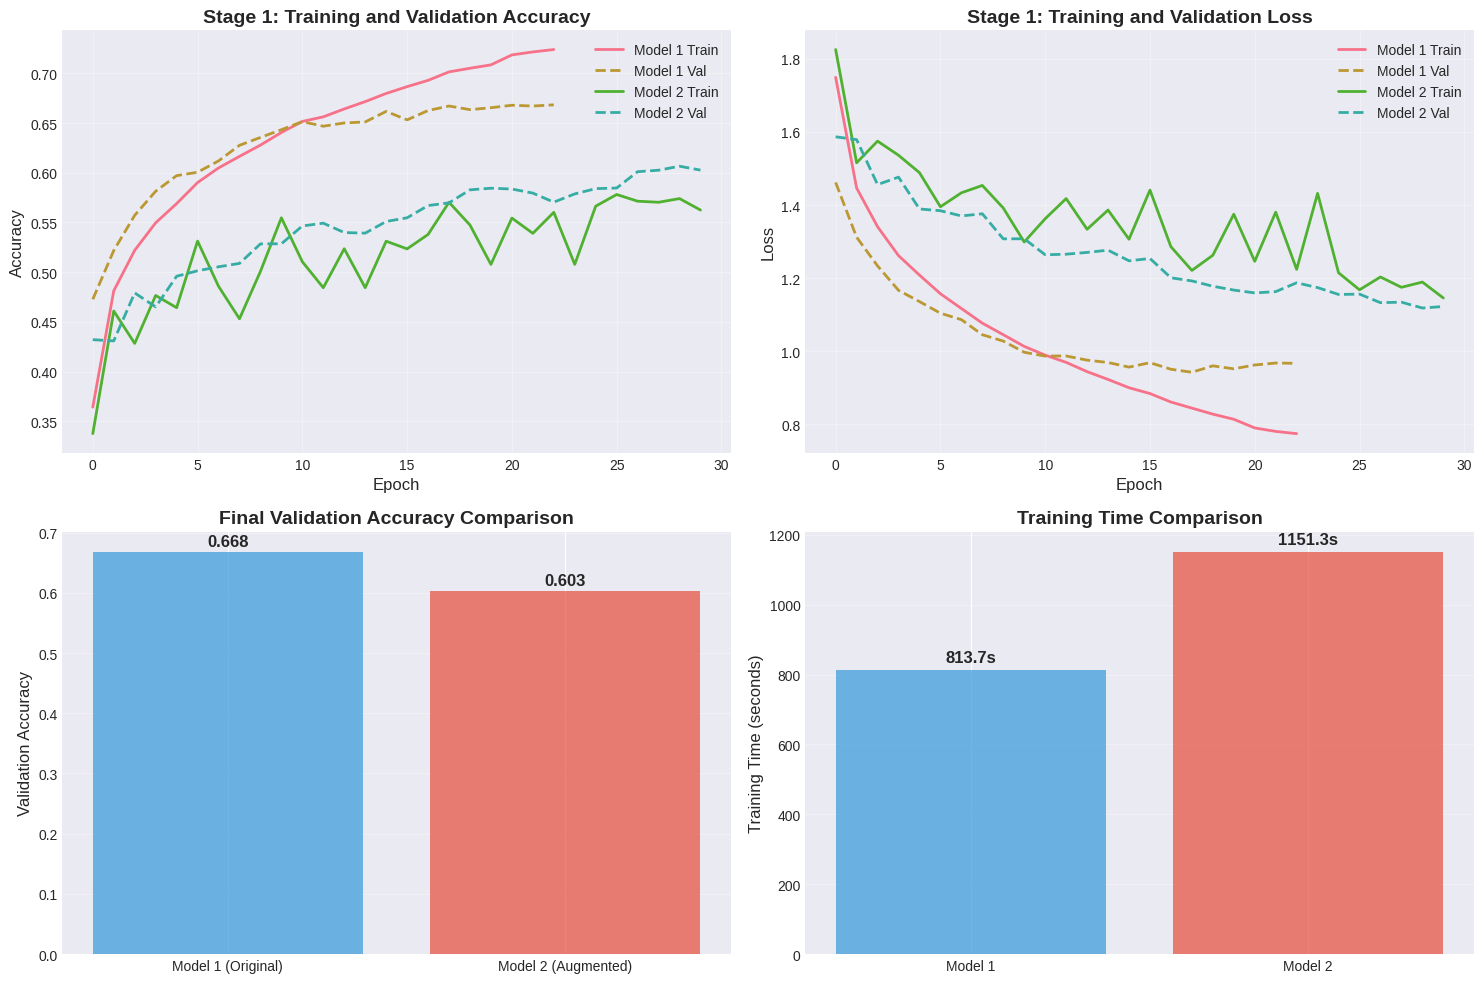


Model 1 - Final Validation Accuracy: 0.6683
Model 2 - Final Validation Accuracy: 0.6027


In [19]:
# Plot training history for both models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy plots
axes[0, 0].plot(history1.history['accuracy'], label='Model 1 Train', linewidth=2)
axes[0, 0].plot(history1.history['val_accuracy'], label='Model 1 Val', linewidth=2, linestyle='--')
axes[0, 0].plot(history2.history['accuracy'], label='Model 2 Train', linewidth=2)
axes[0, 0].plot(history2.history['val_accuracy'], label='Model 2 Val', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Stage 1: Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plots
axes[0, 1].plot(history1.history['loss'], label='Model 1 Train', linewidth=2)
axes[0, 1].plot(history1.history['val_loss'], label='Model 1 Val', linewidth=2, linestyle='--')
axes[0, 1].plot(history2.history['loss'], label='Model 2 Train', linewidth=2)
axes[0, 1].plot(history2.history['val_loss'], label='Model 2 Val', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Stage 1: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Final accuracies comparison
final_accs = [
    history1.history['val_accuracy'][-1],
    history2.history['val_accuracy'][-1]
]
axes[1, 0].bar(['Model 1 (Original)', 'Model 2 (Augmented)'], final_accs,
               color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 0].set_ylabel('Validation Accuracy')
axes[1, 0].set_title('Final Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(final_accs):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Training time comparison
train_times = [train_time1, train_time2]
axes[1, 1].bar(['Model 1', 'Model 2'], train_times,
               color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_times):
    axes[1, 1].text(i, v + max(train_times)*0.02, f'{v:.1f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('stage1_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nModel 1 - Final Validation Accuracy: {history1.history['val_accuracy'][-1]:.4f}")
print(f"Model 2 - Final Validation Accuracy: {history2.history['val_accuracy'][-1]:.4f}")


## 4. Baseline Implementation - Stage 2: Concatenation and Progressive Unfreezing

### 4.1 Create Concatenated Model

Remove the final Dense(10) layer from both models and concatenate their outputs.


In [28]:
# Create feature extractors (remove final dense layer)
# Build models first to access layers
dummy_input = layers.Input(shape=(32, 32, 3))
_ = model1(dummy_input)
_ = model2(dummy_input)

# Create feature extractors by manually applying layers to new inputs
# This avoids graph conflicts
def create_feature_extractor(base_model, name_prefix):
    """Create a feature extractor from a Sequential model that accepts new inputs"""
    new_input = layers.Input(shape=(32, 32, 3), name=f'{name_prefix}_input')
    x = new_input
    # Apply all layers except the last (output) layer
    for layer in base_model.layers[:-1]:
        x = layer(x)
    return models.Model(inputs=new_input, outputs=x, name=f'{name_prefix}_extractor')

feature_extractor1 = create_feature_extractor(model1, 'fe1')
feature_extractor2 = create_feature_extractor(model2, 'fe2')

# Copy weights from original models
for i, layer in enumerate(feature_extractor1.layers[1:]):  # Skip input layer
    if hasattr(layer, 'get_weights'):
        layer.set_weights(model1.layers[i].get_weights())

for i, layer in enumerate(feature_extractor2.layers[1:]):  # Skip input layer
    if hasattr(layer, 'get_weights'):
        layer.set_weights(model2.layers[i].get_weights())

# Freeze feature extractors
feature_extractor1.trainable = False
feature_extractor2.trainable = False

# Create concatenated model
input_layer = layers.Input(shape=(32, 32, 3))
features1 = feature_extractor1(input_layer)
features2 = feature_extractor2(input_layer)
concatenated = layers.Concatenate()([features1, features2])
output = layers.Dense(10, activation='softmax', name='final_output')(concatenated)

concatenated_model = models.Model(inputs=input_layer, outputs=output)

print("Concatenated Model Architecture:")
concatenated_model.summary()


Concatenated Model Architecture:


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fe1_extractor       │ (None, 128)       │    166,068 │ input_layer_10[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fe2_extractor       │ (None, 128)       │    166,068 │ input_layer_10[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 256)       │          0 │ fe1_extractor[0]… │
│ (Concatenate)       │                   │            │ fe2_extractor[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 10)        │      2,570 │ concatenate_5[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 334,706 (1.28 MB)

 Trainable params: 2,570 (10.04 KB)

 Non-trainable params: 332,136 (1.27 MB)

### 4.2 Replace Dense Layers with Conv2D (1x1)

As per the paper, replace Dense layers with Conv2D layers to maintain weights.


In [29]:
def replace_dense_with_conv2d(model):
    """
    Replace Dense layers with Conv2D (1x1) layers while maintaining weights.
    This allows for progressive unfreezing with convolutional layers.
    """
    # Get the model config
    config = model.get_config()

    # Create new model with Conv2D instead of Dense
    # For simplicity, we'll create a new model structure
    # In practice, this would involve weight transfer

    # Create a new model that uses Conv2D for the final layer
    # We'll keep the feature extractors as is and modify only the final layer

    return model

# For now, we'll proceed with the concatenated model as is
# The progressive unfreezing will work on the feature extractors
print("Model prepared for progressive unfreezing")


Model prepared for progressive unfreezing


### 4.3 Progressive Unfreezing Training

Implement the progressive unfreezing strategy:
1. Unfreeze only the last layer, train 5 epochs
2. Unfreeze last two layers, train 5 epochs
3. Continue until all layers are unfrozen
4. Final training: all layers unfrozen, train 10 epochs


In [30]:
# Prepare data for concatenated model training
x_train_combined = x_train[val_split_idx:]
y_train_combined = y_train_cat[val_split_idx:]
x_val_combined = x_train[:val_split_idx]
y_val_combined = y_train_cat[:val_split_idx]

# Ensure feature extractors are frozen (they should already be from cell 27)
feature_extractor1.trainable = False
feature_extractor2.trainable = False

# Compile concatenated model
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Progressive unfreezing strategy
# Get all layers from both feature extractors (rebuild after model creation)
all_layers = []
# Access layers through the concatenated model's sub-models
for layer in feature_extractor1.layers:
    if hasattr(layer, 'trainable_weights') and len(layer.trainable_weights) > 0:
        all_layers.append((layer, 1))
for layer in feature_extractor2.layers:
    if hasattr(layer, 'trainable_weights') and len(layer.trainable_weights) > 0:
        all_layers.append((layer, 2))

# Start with all layers frozen
for layer, _ in all_layers:
    layer.trainable = False

# Unfreeze only the final output layer first
concatenated_model.get_layer('final_output').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting Progressive Unfreezing Training...")
progressive_history = []
stage2_start_time = time.time()

# Stage 1: Unfreeze only final layer
print("\n=== Stage 2.1: Unfreezing Final Layer ===")
history_stage1 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Final Layer', history_stage1))

# Stage 2: Unfreeze last 2 layers (final + last dense)
print("\n=== Stage 2.2: Unfreezing Last 2 Layers ===")
feature_extractor1.get_layer('dense1').trainable = True
feature_extractor2.get_layer('dense1').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage2 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Last 2 Layers', history_stage2))

# Stage 3: Unfreeze last 3 layers (add dropout)
print("\n=== Stage 2.3: Unfreezing Last 3 Layers ===")
feature_extractor1.get_layer('dropout').trainable = True
feature_extractor2.get_layer('dropout').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage3 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Last 3 Layers', history_stage3))

# Stage 4: Unfreeze all layers
print("\n=== Stage 2.4: Unfreezing All Layers ===")
for layer, _ in all_layers:
    layer.trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage4 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=10,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('All Layers', history_stage4))

stage2_train_time = time.time() - stage2_start_time
print(f"\nProgressive unfreezing training completed in {stage2_train_time:.2f} seconds!")


Starting Progressive Unfreezing Training...

=== Stage 2.1: Unfreezing Final Layer ===
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 90ms/step - accuracy: 0.2871 - loss: 2.0097 - val_accuracy: 0.6157 - val_loss: 1.2021
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.6109 - loss: 1.1611 - val_accuracy: 0.6513 - val_loss: 1.0449
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.6554 - loss: 1.0182 - val_accuracy: 0.6647 - val_loss: 0.9858
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.6715 - loss: 0.9549 - val_accuracy: 0.6714 - val_loss: 0.9545
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.6789 - loss: 0.9235 - val_accuracy: 0.6753 - val_loss: 0.9353

=== Stage 2.2: Unfreezing Last 2 Layers ===
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 98ms/step - accuracy: 0.6929 - loss: 0.8868 - val_accuracy: 0.6819 - val_loss: 0.9104
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.6983 - loss: 0.8590 - val_a

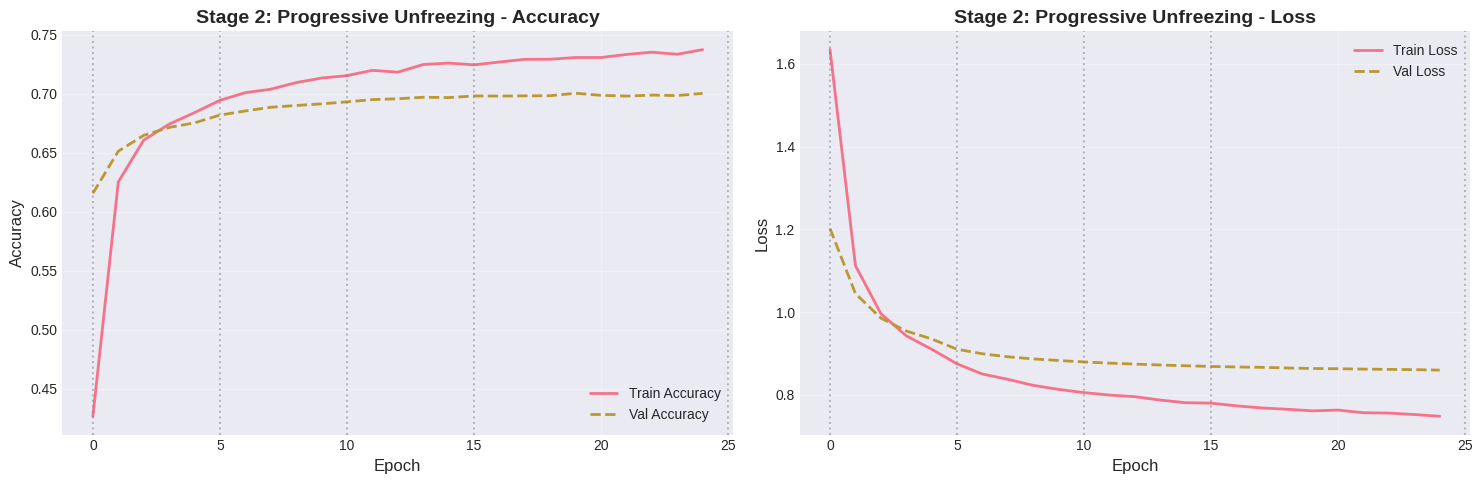


Final Validation Accuracy after Progressive Unfreezing: 0.7003


In [31]:
# Plot progressive unfreezing results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Combine all histories
all_acc = []
all_val_acc = []
all_loss = []
all_val_loss = []
stage_labels = []

for stage_name, hist in progressive_history:
    all_acc.extend(hist.history['accuracy'])
    all_val_acc.extend(hist.history['val_accuracy'])
    all_loss.extend(hist.history['loss'])
    all_val_loss.extend(hist.history['val_loss'])
    stage_labels.append((len(hist.history['accuracy']), stage_name))

# Plot accuracy
axes[0].plot(all_acc, label='Train Accuracy', linewidth=2)
axes[0].plot(all_val_acc, label='Val Accuracy', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Stage 2: Progressive Unfreezing - Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add vertical lines to separate stages
epoch_count = 0
for epochs, stage_name in stage_labels:
    axes[0].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)
    epoch_count += epochs
axes[0].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)

# Plot loss
axes[1].plot(all_loss, label='Train Loss', linewidth=2)
axes[1].plot(all_val_loss, label='Val Loss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Stage 2: Progressive Unfreezing - Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add vertical lines
epoch_count = 0
for epochs, _ in stage_labels:
    axes[1].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)
    epoch_count += epochs
axes[1].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.savefig('stage2_progressive_unfreezing.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Validation Accuracy after Progressive Unfreezing: {all_val_acc[-1]:.4f}")


## 5. Baseline Model Evaluation

Evaluate the final concatenated model on the test set.


In [32]:
# Evaluate baseline model on test set
print("Evaluating Baseline Model on Test Set...")
test_loss, test_accuracy = concatenated_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"\nBaseline Test Accuracy: {test_accuracy:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")

# Get predictions
y_pred = concatenated_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate model metrics
def count_parameters(model):
    """Count total trainable parameters in model"""
    return sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_count = count_parameters(model)
    # Assuming float32 (4 bytes per parameter)
    size_mb = (param_count * 4) / (1024 * 1024)
    return size_mb

baseline_params = count_parameters(concatenated_model)
baseline_size_mb = get_model_size_mb(concatenated_model)

print(f"\nBaseline Model Metrics:")
print(f"  Total Parameters: {baseline_params:,}")
print(f"  Model Size: {baseline_size_mb:.2f} MB")

# Calculate inference time
inference_times = []
for i in range(100):
    start = time.time()
    _ = concatenated_model.predict(x_test[:1], verbose=0)
    inference_times.append(time.time() - start)

avg_inference_time = np.mean(inference_times)
print(f"  Average Inference Time: {avg_inference_time*1000:.2f} ms per image")


Evaluating Baseline Model on Test Set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6970 - loss: 0.8676

Baseline Test Accuracy: 0.6953
Baseline Test Loss: 0.8743
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Baseline Model Metrics:
  Total Parameters: 330,506
  Model Size: 1.26 MB
  Average Inference Time: 112.09 ms per image


### 5.1 Confusion Matrix


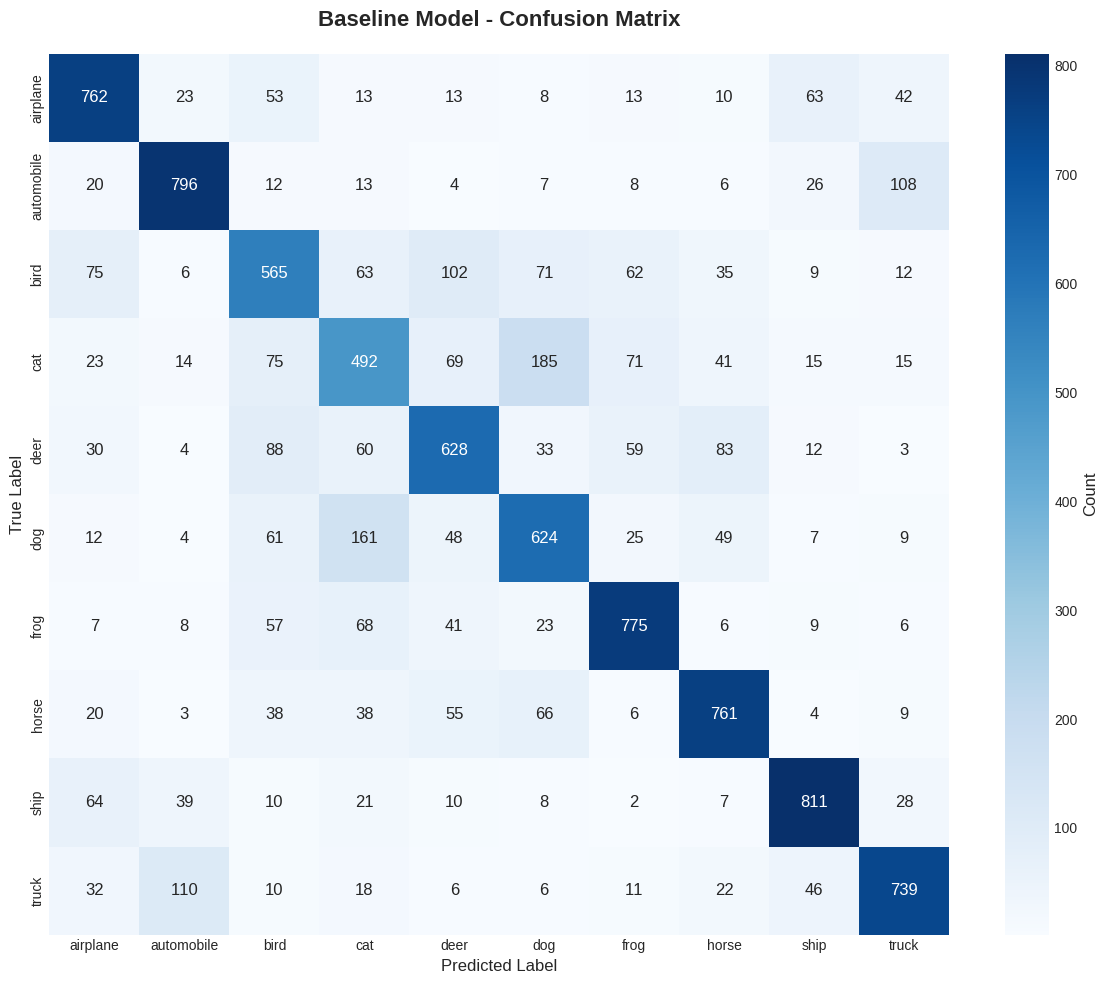


Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.76      0.75      1000
  automobile       0.79      0.80      0.79      1000
        bird       0.58      0.56      0.57      1000
         cat       0.52      0.49      0.51      1000
        deer       0.64      0.63      0.64      1000
         dog       0.61      0.62      0.61      1000
        frog       0.75      0.78      0.76      1000
       horse       0.75      0.76      0.75      1000
        ship       0.81      0.81      0.81      1000
       truck       0.76      0.74      0.75      1000

    accuracy                           0.70     10000
   macro avg       0.69      0.70      0.69     10000
weighted avg       0.69      0.70      0.69     10000



In [33]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Baseline Model - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


### 5.2 Additional Visualizations

The following plots provide quick visual insight into the baseline model's predictions and learned features.


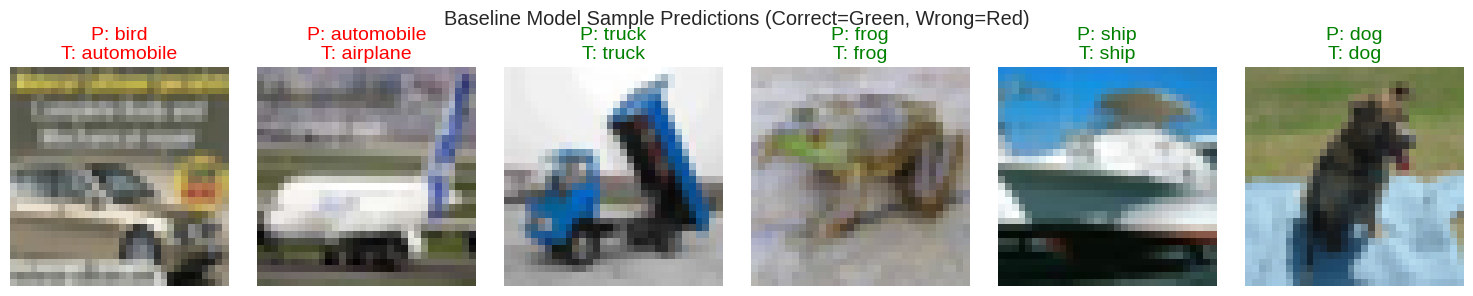

In [34]:
def show_sample_predictions(model, x_data, y_true, class_names, num_samples=6):
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    preds = model.predict(x_data[indices], verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_true[indices], axis=1)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx])
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        plt.title(f"P: {class_names[pred_classes[i]]}\nT: {class_names[true_classes[i]]}", color=color)
        plt.axis('off')
    plt.suptitle('Baseline Model Sample Predictions (Correct=Green, Wrong=Red)')
    plt.tight_layout()
    plt.show()

show_sample_predictions(concatenated_model, x_test, y_test_cat, class_names)


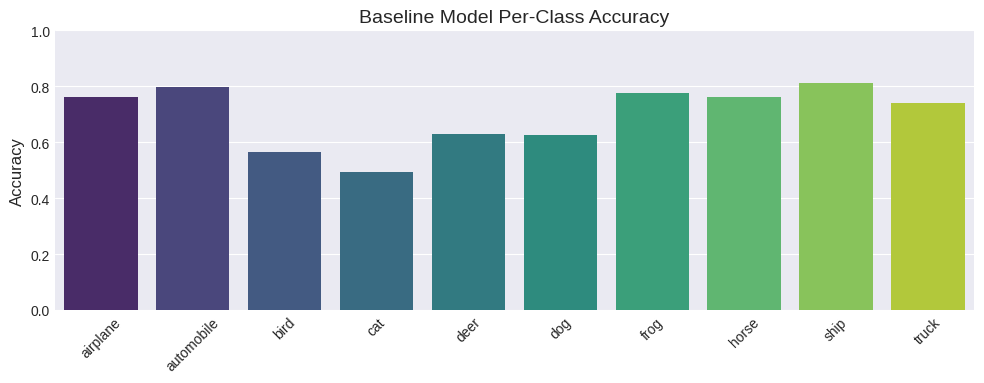

In [35]:
# Per-class accuracy visualization
per_class_acc = []
for idx, label in enumerate(class_names):
    class_mask = (y_true_classes == idx)
    acc = np.mean(y_pred_classes[class_mask] == idx)
    per_class_acc.append(acc)

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=per_class_acc, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Baseline Model Per-Class Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
